# Example of usage of CNF to learn the distribution of digits in the MNIST dataset
In this example, a CNF model is trained on MNIST images so it can generate new hand-written digits. The architecture of the model is the same as in the experiment conducted by Grathwohl, Chen, et al. in FFJORD: Free-form continuous dynamics for scalable reversible generative models ([arxiv](https://arxiv.org/abs/1810.01367)). The model has been simplifed in order to be trained faster in a single GPU (if available). The model is trained for 500 epochs using an Adam optimiser. The dimensions and number of blocks have been decreased. This leads to a model with only 31107 parameters, which still take days to train due to the complexity of the data.

*Disclaimer*: This example is not meant to be a state-of-the-art model for generating hand-written digits. It is just a simple example of how to use CNF to learn the distribution of MNIST digits. This notebook was created by the author to make the code easier to follow and understand the training procedure, but the model is based on the code provided by the authors of FFJORD ([GitHub](https://github.com/rtqichen/ffjord)).

In [1]:
import os
import torch
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as tforms
from torchvision.utils import save_image
import numpy as np
import time

import modelling.odenvp as odenvp
from modelling.layers.cnf import CNF
from modelling.layers.odefunc import ODEfunc
from application_examples.helpers.training import RunningAverageMeter
from modelling.utils import count_total_time

import matplotlib.pyplot as plt
import torchvision

In [2]:
args = {
    'resume': None,     # Change to directory where the model is stored to resume training
    'begin_epoch': 1,   # Change to last epoch to resume training
    'dims': "16, 16, 16",
    'strides': "1, 1, 1, 1",
    'num_blocks': 1,
    'num_epochs': 500,
    'val_freq': 5,
    'batch_size': 200,
    'test_batch_size': 200,
    'nonlinearity': 'softplus',
    'alpha': 1e-6,
    'time_length': 1.0,
    'warmup_iters': 1000,
    'lr': 0.001,
    'solver': 'dopri5',
    'atol': 1e-5,
    'rtol': 1e-5,
    'step_size': None,
    'weight_decay': 0.0,
}

# Load data

In [4]:
def add_noise(x):
    noise = x.new().resize_as_(x).uniform_()
    x = x * 255 + noise
    x = x / 256
    return x

In [5]:
def get_dataset():
    trans = lambda im_size: tforms.Compose([
        tforms.Resize(im_size),
        tforms.ToTensor(),
        add_noise
    ])
    
    im_dim = 1
    im_size = 28
    train_set = dset.MNIST(root="./data", train=True, transform=trans(im_size), download=True)
    test_set = dset.MNIST(root="./data", train=False, transform=trans(im_size), download=True)
    
    data_shape = (im_dim, im_size, im_size)
    
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=args['test_batch_size'],
        shuffle=False
    )
    
    return train_set, test_loader, data_shape
train_set, test_loader, data_shape = get_dataset()

In [6]:
def get_train_loader(train_set):
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=args['batch_size'],
        shuffle=True,
        drop_last=True,
        pin_memory=True
    )
    print("Using batch size {}. Total {} iterations/epoch.".format(args['batch_size'], len(train_loader)))
    return train_loader

# Define model

The model

In [7]:
hidden_dims = tuple(map(int, args['dims'].split(',')))
strides = tuple(map(int, args['strides'].split(',')))

model = odenvp.ODENVP(
    input_size=(args['batch_size'], *data_shape),
    n_blocks=args['num_blocks'],
    intermediate_dims=hidden_dims,
    nonlinearity=args['nonlinearity'],
    alpha=args['alpha'],
    cnf_kwargs={'T': args['time_length'], 'train_T': args.get('train_T', True) }
)

Using 3 scales


In [8]:
def set_cnf_options(args, model):

    def _set(module):
        if isinstance(module, CNF):
            # Set training settings
            module.solver = args['solver']
            module.atol = args['atol']
            module.rtol = args['rtol']
            if args['step_size'] is not None:
                module.solver_options['step_size'] = args['step_size']

            # Set the test settings
            module.test_solver = args.get('test_solver', args['solver'])
            module.test_atol = args.get('test_atol', args['atol'])
            module.test_rtol = args.get('test_rtol', args['rtol'])

        if isinstance(module, ODEfunc):
            module.rademacher = args.get('rademacher', True)
            module.residual = args.get('residual', False)

    model.apply(_set)

# Define loss
CNF are trained using minimum negative log-likelihood (NLL) loss. The following function computes the bits per dimension (BPD) loss, which is equivalent.

More precisely, given an image $z$ with values in the $[0,256]$ range, one computes bits per pixel as
$$
b(z) = -\frac{\log_2p_d(z)}{D},
$$
where $p_d$ is the probability density associated with the images sampled from the space $[0,256]^D$ and $D$ the dimension.

When working with CNF, the pixels have continuous values in the $[0,1]$ range. Let $p$ denote the probability density in such space and $x$ an image in it. To account for discretisation, one can obtain $p_d$ as
$$
p_d(z) = \frac{p\left(\frac{z}{256}\right)}{256} = \frac{p(x)}{256},
$$
where the change of variables $z = 256 x$ was used.

Finally, using this one obtains
$$
b(x) = -\frac{\left(\frac{\log p(x)}{D} - \log 256 \right)}{\log 2}.
$$

In [9]:
def standard_normal_logprob(z):
    log_z = -0.5 * np.log(2 * np.pi)
    return log_z - z.pow(2) / 2

In [10]:
def bits_per_dim(x, model):
    zero = torch.zeros(x.shape[0], 1).to(x)
    z, delta_logp = model(x, zero)
    
    logpz = standard_normal_logprob(z).view(z.shape[0], -1).sum(1, keepdim=True)
    logpx = logpz - delta_logp
    
    logpx_per_dim = torch.sum(logpx) / x.nelement()
    
    return -(logpx_per_dim - np.log(256)) / np.log(2)
    

# Train
The following cells are the training loop. At each epoch an image is generated using the model and saved in the folder `mnist_results`. The best model is saved in the file `mnist_odenvp_best.pth`. The model can be resumed from the last saved checkpoint by setting the `resume` argument to the path of the checkpoint. The current loss is printed every 10 iterations and the model is validated every `args['val_freq']` epochs.

In [11]:
def update_lr(optimizer, itr):
    iter_frac = min(float(itr + 1) / max(args['warmup_iters'], 1), 1.)
    lr = args['lr'] * iter_frac
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [12]:
# Get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device {}.".format(device))

cvt = lambda x: x.type(torch.float32).to(device, non_blocking=True)

set_cnf_options(args, model)

print("Number of trainable parameters: {}.".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

if args['resume'] is not None:
    print('Resuming training')
    checkpoint = torch.load(args['resume'], map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['state_dict'])
    if 'optim_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        # Manually move optimizer state to device
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
                    
# If possible, parallelize the computation
if torch.cuda.is_available():
    model = torch.nn.DataParallel(model)
    print("Parallelizing computation.")
    
# Get 100 random samples from normal distribution to visualize the model
fixed_z = cvt(torch.randn(100, *data_shape))

# Set up the average meters
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)
grad_meter = RunningAverageMeter(0.97)
tt_meter = RunningAverageMeter(0.97)

# Keep track of current best performance
best_loss = float('inf')

# Start training
itr = 0
for epoch in range(args['begin_epoch'], args['num_epochs'] + 1):
    # Set model to training mode
    model.train()
    
    # Get train loader
    train_loader = get_train_loader(train_set)
    
    for x, y in train_loader:
        # Set starting time of epoch iteration
        start = time.time()
        
        # Update learning rate
        update_lr(optimizer, itr)
        optimizer.zero_grad()
        
        # Move data to device
        x = cvt(x)
        #Compute loss
        loss = bits_per_dim(x, model)
        
        total_time = count_total_time(model)
        
        # Backpropagate and update parameters
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 100) # 100 is the max norm
        
        optimizer.step()
        
        # Update average meters
        time_meter.update(time.time() - start)
        loss_meter.update(loss.item())
        grad_meter.update(grad_norm)
        tt_meter.update(total_time)
        
        # Log progress
        if itr % args.get('log_freq', 10) == 0:
            print(
                    "Epoch {}:Iter {:04d} | Time {:.4f}({:.4f}) | Bit/dim {:.4f}({:.4f}) | Grad Norm {:.4f}({:.4f}) | Total Time {:.2f}({:.2f})".format(
                        epoch, itr, time_meter.val, time_meter.avg, loss_meter.val, loss_meter.avg, grad_meter.val, grad_meter.avg, tt_meter.val, tt_meter.avg
                    )
            )
            
        itr += 1
        
    # Compute validation loss
    model.eval()
    
    if epoch % args['val_freq'] == 0:
        with torch.no_grad():
            start = time.time()
            print("Validating...")
            losses = []
            for x, y in test_loader:
                x = cvt(x)
                losses.append(bits_per_dim(x, model))
                
            loss = torch.mean(torch.stack(losses)).item()
            print("Epoch {} Validation Loss {:.4f} Time {:.4f}".format(epoch, loss, time.time() - start))
            
            # Save model if it is the best so far
            if loss < best_loss:
                best_loss = loss
                if not os.path.exists('results'):
                    os.makedirs('results')
                torch.save({
                    'args': args,
                    'state_dict': model.state_dict(),
                    'optim_state_dict': optimizer.state_dict()
                }, 'mnist_odenvp_best.pth')

    # Visualize the model
    with torch.no_grad():
        fig_filename = os.path.join('mnist_results', "{}.jpg".format(epoch))
        if not os.path.exists('mnist_results'):
            os.makedirs('mnist_results')
        generated_samples = model(fixed_z, reverse=True).view(-1, *data_shape)
        save_image(generated_samples, fig_filename, nrow=10)

Using device cuda:0.
Number of trainable parameters: 31107.
Parallelizing computation.
Using batch size 200. Total 300 iterations/epoch.
Epoch 1:Iter 0000 | Time 7.1893(7.1893) | Bit/dim 26.8271(26.8271) | Grad Norm 79.4331(79.4331) | Total Time 5.00(5.00)
Epoch 1:Iter 0010 | Time 1.2389(5.6373) | Bit/dim 26.6355(26.8152) | Grad Norm 79.9443(79.6630) | Total Time 5.00(5.00)
Epoch 1:Iter 0020 | Time 1.2496(4.4899) | Bit/dim 25.8767(26.6709) | Grad Norm 79.0694(79.5363) | Total Time 5.00(5.00)
Epoch 1:Iter 0030 | Time 1.2990(3.6342) | Bit/dim 24.8956(26.3182) | Grad Norm 76.5492(78.9872) | Total Time 5.00(5.00)
Epoch 1:Iter 0040 | Time 1.2006(3.0080) | Bit/dim 23.4505(25.7128) | Grad Norm 74.5683(78.0589) | Total Time 5.00(5.00)
Epoch 1:Iter 0050 | Time 1.1904(2.5384) | Bit/dim 21.5254(24.8256) | Grad Norm 70.9354(76.7291) | Total Time 5.00(5.00)
Epoch 1:Iter 0060 | Time 1.1954(2.1941) | Bit/dim 19.4712(23.6597) | Grad Norm 69.5816(75.0782) | Total Time 5.00(5.00)
Epoch 1:Iter 0070 | Tim

## Results
Let's see what the best model generates. Notice that each image is generated from a random sample, so the results may vary.

In [13]:
hidden_dims = tuple(map(int, args['dims'].split(',')))
strides = tuple(map(int, args['strides'].split(',')))

best_model = odenvp.ODENVP(
    input_size=(args['batch_size'], *data_shape),
    n_blocks=args['num_blocks'],
    intermediate_dims=hidden_dims,
    nonlinearity=args['nonlinearity'],
    alpha=args['alpha'],
    cnf_kwargs={'T': args['time_length'], 'train_T': args.get('train_T', True) } #, 'regularization_fns': ()
)

set_cnf_options(args, best_model)
if torch.cuda.is_available():
    best_model = torch.nn.DataParallel(best_model)

Using 3 scales


In [14]:
# Load mnist_odenvp_best.pth
loaded_checkpoint = torch.load('mnist_odenvp_best.pth')
best_model.load_state_dict(loaded_checkpoint['state_dict'])

<All keys matched successfully>

Set model in eval mode and run a series of samples through it.

In [67]:
best_model.eval()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cvt = lambda x: x.type(torch.float32).to(device, non_blocking=True)
fixed_z = cvt(torch.randn(100, *data_shape))
generated_samples = best_model(fixed_z, reverse=True).view(-1, *data_shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


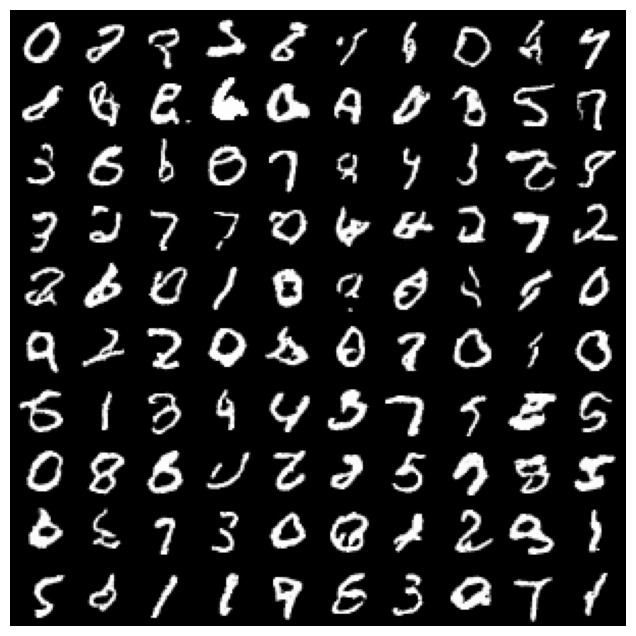

In [68]:
# Convert the torch tensor to a NumPy array
generated_samples_np = torchvision.utils.make_grid(generated_samples, nrow=10).cpu().numpy()

# Transpose the array to have channels as the last dimension (if needed)
generated_samples_np = generated_samples_np.transpose((1, 2, 0))

# Display the images using matplotlib
plt.figure(figsize=(14, 8))
plt.imshow(generated_samples_np)
plt.axis('off')
plt.show()